In [35]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../df.csv')
df

,user_id,movie_id,review,rating
0,1,10001,전체관람가는 아닌것 같아요,10
1,2,10001,디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다,10
2,3,10001,태어나 처음으로 가슴아리는 영화였다. 20년이상 지났지만.. 생각하면 또 가슴이...,10
3,4,10001,어린시절 고딩때 봤던 때랑 또 결혼하고 나서 봤을때의 느낌은 확실히 다르네요. 뭔가...,10
4,5,10001,토토에게 넓은 세상을 보여주고픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 장...,10
...,...,...,...,...
712399,4031,99876,아직까지 여운이.... 우연히 봤다가 펑펑 울었네요. 음악때문에 감동이 백배!,10
712400,9870,99876,쓸쓸한 가을 감성을 채워주는 영화네요.. 사랑하고시프다...,9
712401,7078,99876,단언컨대 올 가을 최고의 영화!! 장담한다!!,10
712402,36911,99876,기대없이 봤다가 너무너무 반하게 된 영화! 가을 감성에 딱!,9


In [4]:
# 데이터프레임을 랜덤하게 섞음
df_shuffled = df.sample(frac=1, random_state=42)  

df_shuffled['rating'] = df_shuffled['rating'].astype(float)
df_shuffled['label'] = df_shuffled['rating'].apply(lambda x: 1 if x > 5 else 0)

# 긍정 리뷰와 부정 리뷰 분리
positive_reviews = df_shuffled[df_shuffled['label'] == 1]
negative_reviews = df_shuffled[df_shuffled['label'] == 0]
print(len(positive_reviews)) #560031
print(len(negative_reviews)) #152373

# 클래스 균형을 맞추기 위해 샘플 수 결정
num_samples = min(len(positive_reviews), len(negative_reviews))
print(num_samples) #152373

# 데이터를 샘플링하여 균형 잡힌 데이터셋 생성
positive_samples = positive_reviews.sample(num_samples, random_state=42)
negative_samples = negative_reviews.sample(num_samples, random_state=42)

balanced_df = pd.concat([positive_samples, negative_samples])
balanced_df = balanced_df.sample(frac=1, random_state = 42)
balanced_df.reset_index(inplace= True, drop= True)

560031
152373
152373


In [5]:
data = balanced_df[['review', 'rating', 'label']]
data

,review,rating,label
0,정말 최고네요. 신의 퀴즈 시즌2 화이팅 시즌3까지 갑시다.,10.0,1
1,완전 짜증?내 두시간이 너무 아깝다. 평점을 믿었던 내가 더 바보. 영화보다 짜증나...,1.0,0
2,갈등의 요소가 병콜라일 수 있다는. 에피소드가 재미난다,9.0,1
3,웃기면서 슬프다 ㅋㅋㅋㅋ,8.0,1
4,늦은밤 최고의 영화한편 그 감동이 아직도 ..,10.0,1
...,...,...,...
304741,기대안하고 봤는데 첫부분 30분은 지루하지만 중반부로 넘어가면서 몰입감있게 봄,10.0,1
304742,'우리'는 어쩌면 인생을 너무 심각하게 생각하는것일지도....,5.0,0
304743,새삼스러운 깨달음이 주는 유쾌함,10.0,1
304744,여러가지로 기억에 남는 영화. 독특하고 섬찟하고 여배우 예뻤음.,10.0,1


In [21]:
data_emotion = data[:50000]
data_recommend = data[50001 : ]

data_recommend.to_csv('../data_recommend.csv')

In [22]:
data_emotion.dropna(axis= 0, how= 'any', inplace= True)

C:\Users\USER\AppData\Local\Temp\ipykernel_31908\4265568849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emotion.dropna(axis= 0, how= 'any', inplace= True)


In [17]:
def text_cleaning(text) :
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
  result = hangul.sub('', text)
  return result

In [ ]:
data_emotion['ko_review'] = data_emotion['review'].apply(lambda x : text_cleaning(x))
del data_emotion['review']
data_emotion['ko_review'] = data_emotion['ko_review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
data_emotion['ko_review'].replace('', np.nan, inplace=True)
print(data_emotion.isnull().sum())

In [28]:
data_emotion = data_emotion.dropna(how = 'any' , axis = 0)
data_emotion.reset_index(drop = True, inplace = True)
data_emotion #49762


,rating,label,ko_review
0,10.0,1,정말 최고네요 신의 퀴즈 시즌 화이팅 시즌까지 갑시다
1,1.0,0,완전 짜증내 두시간이 너무 아깝다 평점을 믿었던 내가 더 바보 영화보다 짜증나는게 ...
2,9.0,1,갈등의 요소가 병콜라일 수 있다는 에피소드가 재미난다
3,8.0,1,웃기면서 슬프다 ㅋㅋㅋㅋ
4,10.0,1,늦은밤 최고의 영화한편 그 감동이 아직도
...,...,...,...
49757,7.0,1,쓸쓸한인생이여
49758,8.0,1,어릴 때 봤는데 아이디어는 좋았지ㅋㅋ
49759,5.0,0,여주는이뻤다 전형적인 흥미로운소재의 지루한텔링
49760,6.0,1,난 홍상수가이젠왜영화를만드는지모르겠다값싸게만들수있는기회가그에게너무쉽게오나왠지그가싸낸...


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [37]:
okt = Okt()

def get_token(x) :
  tokenized_sentence = okt.morphs(x, stem = True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  return stopwords_removed_sentence

In [38]:
X = data_emotion[['ko_review']]
X['ko_review'] = X['ko_review'].apply(get_token) #10만개 32m 52.3s / 5만개 16m 52.9s
y = data_emotion[['label']]

C:\Users\USER\AppData\Local\Temp\ipykernel_31908\2003343989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ko_review'] = X['ko_review'].apply(get_token) #10만개 32m 52.3s / 5만개 16m 52.9s


In [39]:
print(X)
print(y)
print(len(X))
print(len(y))


                                               ko_review
0            [정말, 최고, 네, 요, 신의, 퀴즈, 시즌, 화이팅, 시즌, 까지, 가다]
1      [완전, 짜증, 내, 두, 시간, 너무, 아깝다, 평점, 을, 믿다, 내, 더, 바...
2                [갈등, 요소, 병, 콜라, 일, 수, 있다, 에피소드, 재미, 나다]
3                                       [웃기다, 슬프다, ㅋㅋㅋㅋ]
4                        [늦다, 밤, 최고, 영화, 한편, 그, 감동, 아직도]
...                                                  ...
49757                                     [쓸쓸하다, 인생, 이여]
49758                         [어리다, 때, 보다, 아이디어, 좋다, ㅋㅋ]
49759            [여주, 이쁘다, 전형, 적, 인, 흥미롭다, 소재, 지루하다, 텔링]
49760  [난, 홍상수, 젠왜, 영화, 만들다, 모르다, 값싸다, 만들다, 기회, 그, 게,...
49761                          [깔끔하다, 호러, 틱, 오다, 나다, 알다]

[49762 rows x 1 columns]
       label
0          1
1          0
2          1
3          1
4          1
...      ...
49757      1
49758      1
49759      0
49760      1
49761      1

[49762 rows x 1 columns]
49762
49762


In [40]:
drop_train = [index for index, sentence in enumerate(X['ko_review']) if len(sentence) < 1]
len(drop_train) #149

149

In [41]:
X.drop(index= drop_train, axis= 0, inplace= True)
y.drop(index= drop_train, axis= 0, inplace= True)

print(len(X)) #49613
print(len(y))

49613
49613


C:\Users\USER\AppData\Local\Temp\ipykernel_31908\796985015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index= drop_train, axis= 0, inplace= True)
C:\Users\USER\AppData\Local\Temp\ipykernel_31908\796985015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(index= drop_train, axis= 0, inplace= True)


In [42]:
x_train, x_test, y_train, y_test = train_test_split(X['ko_review'] , y, test_size= 0.2)

In [43]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) # 단어 사전 생성
print(tokenizer.word_index)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test) # 정수 인코딩
y_train = np.array(y_train['label'])
y_test = np.array(y_test['label'])

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '있다': 5, '이다': 6, '좋다': 7, '너무': 8, '만': 9, '적': 10, '다': 11, '되다': 12, '않다': 13, '같다': 14, '아니다': 15, '로': 16, '재밌다': 17, '정말': 18, '점': 19, '에서': 20, '진짜': 21, '나오다': 22, '것': 23, '인': 24, '연기': 25, '그': 26, '만들다': 27, '스토리': 28, '못': 29, '나': 30, '안': 31, '평점': 32, '내': 33, '생각': 34, '더': 35, '그냥': 36, '왜': 37, '게': 38, '사람': 39, '최고': 40, '고': 41, '말': 42, '지루하다': 43, '볼': 44, '재미': 45, '배우': 46, '이렇다': 47, '드라마': 48, '때': 49, '감동': 50, '감독': 51, 'ㅋㅋ': 52, '내용': 53, '거': 54, '아': 55, '자다': 56, '재미있다': 57, '보고': 58, '뭐': 59, '아깝다': 60, '시간': 61, '까지': 62, '주다': 63, '중': 64, '그렇다': 65, '요': 66, '수': 67, '하고': 68, '재미없다': 69, '가다': 70, '모르다': 71, '작품': 72, '사랑': 73, '지': 74, '네': 75, '들다': 76, '싶다': 77, '쓰레기': 78, '알다': 79, '마지막': 80, '액션': 81, '정도': 82, '주인공': 83, '저': 84, '하나': 85, '괜찮다': 86, '이야기': 87, '많다': 88, '장면': 89, '느낌': 90, '별로': 91, '듯': 92, 'ㅋ': 93, '처음': 94, '연출': 95, '다시': 96, '안되다': 97, '이건': 98, '오다': 99, '아쉽다': 100, '차다': 101, '나다'

In [44]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size #23850

23850

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 10.752128999748047


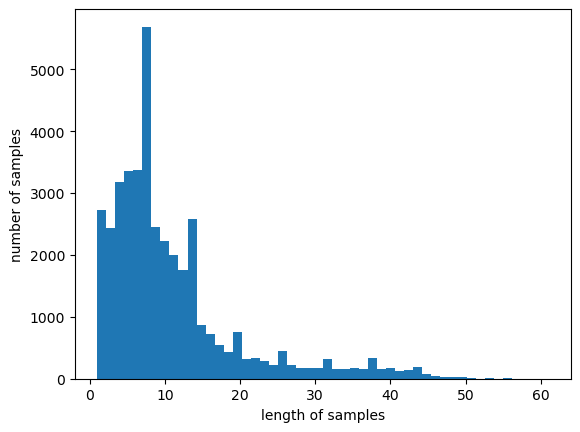

In [45]:
# 패딩
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
review_lengths = [len(review) for review in X_train]
# 95% 이상을 차지하는 리뷰 길이 계산
sorted_lengths = sorted(review_lengths)
percentile_99_length = np.percentile(sorted_lengths, 99)
print('99% 이상을 차지하는 리뷰의 길이:', percentile_99_length)

max_len = int(percentile_99_length)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

99% 이상을 차지하는 리뷰의 길이: 43.0


In [49]:
print(len(X_test))
print(len(y_test)) #9923
print(len(X_train)) #39690

9923
9923
39690


LSTM
###### 은닉층 없는 경우

In [58]:
# 69.885 1m 3.4s - adam
# 68.492 45.1s - rmsprop
# 100,000 79.009% 9m 37.5s - rmsprop
# 100,000 78.555% 8m 21.9s - adam

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam, RMSprop

# 하이퍼파라미터 그리드 설정
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_units': [64, 128, 256],
    'dropout_ratio': [0.3, 0.5, 0.7],
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [20, 30, 40],

}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    embedding_dim = params['embedding_dim']
    hidden_units = params['hidden_units']
    dropout_ratio = params['dropout_ratio']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    optimizer_choice = params['optimizer']
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('LSTM.keras', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, callbacks=[mc], verbose=1)
    
    val_accuracy = max(history.history['val_acc'])
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print('Best Accuracy:', best_accuracy)
print('Best Parameters:', best_params)

Epoch 1/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 98s 80ms/step - acc: 0.5457 - loss: 0.7441 - val_acc: 0.5669 - val_loss: 0.7049
Epoch 2/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - acc: 0.5771 - loss: 0.7195 - val_acc: 0.5928 - val_loss: 0.7005
Epoch 3/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - acc: 0.5751 - loss: 0.7218 - val_acc: 0.5910 - val_loss: 0.7140
Epoch 4/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - acc: 0.6020 - loss: 0.7076 - val_acc: 0.5921 - val_loss: 0.7073
Epoch 5/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - acc: 0.5951 - loss: 0.7147 - val_acc: 0.6024 - val_loss: 0.6891
Epoch 6/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - acc: 0.5887 - loss: 0.7111 - val_acc: 0.5843 - val_loss: 0.7097
Epoch 7/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - acc: 0.5823 - loss: 0.7210 - val_acc: 0.5650 - val_loss: 0.6993
Epoch 8/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - acc: 0.5888 - loss: 0.7143 - val_acc: 0.5781 - val_loss: 0.7116
Epoch 9/40
993/993 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print(model.predict(X_test))
print(model.evaluate(X_test, y_test)[1]) #65%

###### 은닉층 1개

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam, RMSprop


# 하이퍼파라미터 그리드 설정
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_units': [64, 128, 256],
    'dropout_ratio': [0.3, 0.5, 0.7],
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop']
}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    embedding_dim = params['embedding_dim']
    hidden_units = params['hidden_units']
    dropout_ratio = params['dropout_ratio']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    optimizer_choice = params['optimizer']
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dense(hidden_units, activation='relu'))  # 은닉층 추가
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])    

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)    
    mc = ModelCheckpoint('LSTM_hidden1.kears', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, callbacks=[mc], verbose=0)
    
    val_accuracy = max(history.history['val_acc'])
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print('Best Accuracy:', best_accuracy)
print('Best Parameters:', best_params)

In [ ]:
print(model.predict(X_test))
print(model.evaluate(X_test, y_test)[1]) #65%